In [1]:
# IMPORT MODULES REQUIRED FOR API ###
!pip install python-binance
!pip install pyti
!pip install -q matplotlib-venn


     |████████████████████████████████| 368kB 7.3MB/s 
     |████████████████████████████████| 2.7MB 17.3MB/s 
     |████████████████████████████████| 3.1MB 32.8MB/s 
     |████████████████████████████████| 1.5MB 61.3MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 235kB 33.3MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from binance.client import Client
import copy
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.bollinger_bands import upper_bollinger_band as ubb
from pyti.bollinger_bands import middle_bollinger_band as mbb
from pyti.bollinger_bands import lower_bollinger_band as lbb
from pyti.relative_strength_index import relative_strength_index as rsi


%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,LSTM,GRU
import keras

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from keras import backend as K

Using TensorFlow backend.


In [3]:
### METHOD FOR PULLING OHLCV DATA FROM API ###

def get_binance_klines(period='4h'):

  binance_keys = {
      'api_key': "TMu6CGy4SXCHDji8VHexZ18vOQYbrIfQo86hz0EOPpyzhBRIl4wZ1ivmmbEul2tu",
      'api_secret':"x2pzaVdcB36TFEmcnMhJvir6o0qpXJ8foL9LGWAtCpHFcJCfdiah2toJCg7hJl4E"
  }

  client = Client(binance_keys['api_key'],binance_keys['api_secret'])

  if period == '15m':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_15MINUTE,"1 Aug, 2017")

  if period == '4h':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_4HOUR,"1 Aug, 2017")

  if period == '12h':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_12HOUR,"1 Aug, 2017")

  if period == '6h':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_6HOUR,"1 Aug, 2017")

  if period == '1d':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY,"1 Aug, 2017")

  return None

In [4]:
### GENERATE ADDITIONAL TECHNICAL INDICATORS FROM THE OPENING PRICE ###
### INDICATORS INCLUDED: 
#### EMAs: EXPONENTIAL MOVING AVERAGES FOR VARIOUS PERIODS (5-200)
#### BOLLINGER BANDS: UPPER, MIDDLE, LOWER BOLLINGER BAND AND BAND BREADTH
#### MACD: MOVING AVERAGE CONVERGENCE DIVERGENCE
#### RSI: RELATIVE STRENGTH INDEX 

def get_data(klines):
    x = copy.deepcopy(pd.DataFrame(klines)[[1]])
    x.rename(columns={1:"Open"},inplace=True)
    for col in x.columns:
        x[col] = x[col].astype(float)
    
    y_high = copy.deepcopy(pd.DataFrame(klines)[[2]])
    y_high.rename(columns={2:"High"},inplace=True)
    for col in y_high.columns:
        y_high[col] = y_high[col].astype(float)
    
    y_low = copy.deepcopy(pd.DataFrame(klines)[[3]])
    y_low.rename(columns={3:"Low"},inplace=True)
    for col in y_low.columns:
        y_low[col] = y_low[col].astype(float)
    
    y_close = copy.deepcopy(pd.DataFrame(klines)[[4]])
    y_close.rename(columns={4:"Close"},inplace=True)
    for col in y_close.columns:
        y_close[col] = y_close[col].astype(float)
    
    closes = [elem[0] for elem in y_close.values]
    opens = [elem for elem in x['Open'].values]
    diff = [elem[0]-elem[1] for elem in zip(closes,opens)]
    y_status = [1 if elem>=0 else 0 for elem in diff]

    x['low_bollinger'] = lbb(x['Open'].tolist(),20)
    x['high_bollinger'] = ubb(x['Open'].tolist(),20)
    x['band_breadth'] = x['high_bollinger'] - x['low_bollinger']
    x['middle_bollinger'] = mbb(x['Open'].tolist(),20)

    x['rsi'] = rsi(x['Open'].tolist(),20)

    x['ema_5'] = ema(x['Open'].tolist(),6)
    x['ema_10'] = ema(x['Open'].tolist(),10)
    x['ema_15'] = ema(x['Open'].tolist(),10)
    x['ema_20'] = ema(x['Open'].tolist(),10)
    x['ema_25'] = ema(x['Open'].tolist(),10)
    x['ema_30'] = ema(x['Open'].tolist(),10)
    x['ema_35'] = ema(x['Open'].tolist(),10)
    x['ema_40'] = ema(x['Open'].tolist(),10)
    x['ema_45'] = ema(x['Open'].tolist(),10)
    x['ema_50'] = ema(x['Open'].tolist(),10)
    x['ema_60'] = ema(x['Open'].tolist(),10)
    x['ema_70'] = ema(x['Open'].tolist(),10)
    x['ema_80'] = ema(x['Open'].tolist(),10)
    x['ema_90'] = ema(x['Open'].tolist(),10)
    x['ema_100'] = ema(x['Open'].tolist(),100)
    x['ema_200'] = ema(x['Open'].tolist(),200)
    
    x['macd_line'] = ema(x['Open'].tolist(),12) - ema(x['Open'].tolist(),26)
    x['macd_signal'] = ema(x['macd_line'].tolist(),9)
    x['macd_histogram'] = x['macd_line'] - x['macd_signal']

    x['fast_macd_line'] = ema(x['Open'].tolist(),5) - ema(x['Open'].tolist(),35)
    x['fast_macd_signal'] = ema(x['fast_macd_line'].tolist(),5)
    x['fast_macd_histogram'] = x['fast_macd_line'] - x['fast_macd_signal']

    del x['Open']

    x = x[200:]
    y_close = y_close[200:]
    y_high = y_high[200:]
    y_low = y_low[200:]
    y_status = y_status[200:]
    x = x.reset_index(drop=True)
    
    #x,y_close,y_low,y_high = np.array(x),np.array(y_close),np.array(y_low),np.array(y_high)
    
    return x,y_close,y_low,y_high,y_status

In [5]:
### PULL KLINE DATA USING API ###
### NOTE:SUBJECT TO API LIMITS, USE SPARINGLY ###
klines = get_binance_klines('1d')

In [6]:
### GET INPUTS AND LABELS FOR ML MODELS ###
### INPUT - INDICATORS(BOLLINGER BANDS, EMAs, RSI, MACD) CALCULATED ON OPEN PRICE
### LABEL - LOW PRICE / HIGH PRICE / CLOSE PRICE / CANDLE TYPE
x,y_close,y_low,y_high,y_status = get_data(klines)


In [ ]:

def 
### FOR ML CLASSIFICATION TASK, WE USE CANDLE TYPE AS LABELS ###
### SPLIT INPUTS AND LABELS INTO TRAIN/TEST SETS ###
X_train, X_test, Y_train, Y_test = train_test_split(x, y_status, test_size=0.05, shuffle=False)
X_train,X_test, Y_train, Y_test = np.array(X_train),np.array(X_test),np.array(Y_train),np.array(Y_test)

### SCALE DATA ###
input_scaler = StandardScaler()
X_train_std = input_scaler.fit_transform(X_train) 
X_test_std = input_scaler.transform(X_test)

#target_scaler = StandardScaler()
#Y_train_std = target_scaler.fit_transform(Y_train)
#Y_test_std = target_scaler.transform(Y_test)

### COMPRESS DATA ###
input_pca = PCA(n_components=3)
X_train_pca = input_pca.fit_transform(X_train_std)
X_test_pca = input_pca.transform(X_test_std)

In [ ]:
### FOR ML REGRESSION TASK, WE USE CLOSE PRICE AS LABELS ###

### SPLIT INPUTS AND LABELS INTO TRAIN/TEST SETS ###
X_train, X_test, Y_train, Y_test = train_test_split(x, y_close, test_size=0.05, shuffle=False)
X_train,X_test, Y_train, Y_test = np.array(X_train),np.array(X_test),np.array(Y_train),np.array(Y_test)

### SCALE DATA ###
input_scaler = StandardScaler()
X_train_std = input_scaler.fit_transform(X_train) 
X_test_std = input_scaler.transform(X_test)

target_scaler = StandardScaler()
Y_train_std = target_scaler.fit_transform(Y_train)
Y_test_std = target_scaler.transform(Y_test)

### COMPRESS DATA ###
input_pca = PCA(n_components=5)
X_train_pca = input_pca.fit_transform(X_train_std)
X_test_pca = input_pca.transform(X_test_std)

/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


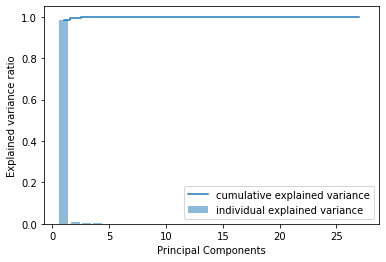

In [ ]:
### PLOT OF PRINCIPAL COMPONENTS' EXPLAINED VARIANCE ###
### WE CAN SEE THAT OUT OF A TOTAL 27 PRINCIPAL COMPONENTS, THE 4 BIGGEST ALONE EXPLAIN MORE THAN 99.9% OF THE VARIANCE IN OUR DATA ###

cov_mat = np.cov(X_train.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals,reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,len(var_exp)+1), var_exp, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(1,len(cum_var_exp)+1),cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
No handles with labels found to put in legend.


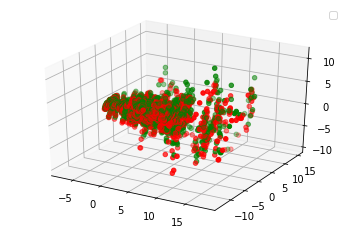

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

### PLOT OF LABELS VS. ALL 5 PRINCIPAL COMPONENTS ###
### LABEL PLOTTED ALONG Y-AXIS###
### PRINCIPAL COMPONENTS PLOTTED ALONG X-AXIS ###
pc1= np.array([row[0] for row in X_train_pca])
pc2= np.array([row[1] for row in X_train_pca])
pc3= np.array([row[2] for row in X_train_pca])

#pc4=np.array([row[3] for row in X_train_pca])
#pc5=np.array([row[4] for row in X_train_pca])

fig = plt.figure()
ax = plt.axes()
ax = fig.gca(projection='3d')

color= ['red' if elem == 0 else 'green' for elem in Y_train]

ax.scatter(pc1, pc2, pc3, color=color)

ax.legend()

In [ ]:
### DATAFRAME ###
np.shape(x),np.shape(y_status)

((5997, 27), (5997,))

In [ ]:
### INPUTS FOR SIMPLE NN MODEL (TRAINING,PREDICTION) ###
np.shape(X_train_pca), np.shape(Y_train)

((5697, 5), (5697,))

In [ ]:
### LABELS FOR THE SIMPLE NN MODEL (TRAINING,PREDICTION) ###
np.shape(X_test_pca), np.shape(Y_test)

((300, 5), (300,))

In [ ]:
### MODEL 1 - SIMPLE DEEP NEURAL NET ### 

### METHOD FOR CREATING NEURAL NET ###
def create_simple_nn(input_shape=(np.shape(X_train_pca)[1],),loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,amsgrad=False),
              metrics = ['accuracy'],
              units = 100,
              activation='sigmoid',
              use_bias=True,
              initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.075,seed=777),
              regularizer=None,
              batch_size=32,
              epochs=1,
              shuffle=False):
    
    simple_nn = Sequential()

    #for layer in range(np.shape(X_train_pca)[1]-1):
    #  simple_nn.add(Dense(units=np.shape(X_train_pca)[1]-layer,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
    #                          kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
    #                          kernel_constraint=None,bias_constraint=None,input_shape=input_shape))


    simple_nn.add(Dense(units=units,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None,input_shape=input_shape))

    simple_nn.add(Dense(units=units//2,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    simple_nn.add(Dense(units=units//4,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    simple_nn.add(Dense(units=units//8,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    simple_nn.add(Dense(units=units//16,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    
    simple_nn.add(Dense(units=1,activation=activation ,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    simple_nn.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    
    #history = simple_nn.fit(x=x_train,y=y_train,batch_size=params['batch_size'],epochs=params['epochs'],verbose=0,callbacks=None,shuffle=True)

    return simple_nn


In [ ]:
### CREATE KerasRegressor MODEL USING PREVIOUS FUNCTION ###
nn_classifier = KerasClassifier(build_fn=create_simple_nn,verbose=1,
                              optimizer=keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
                              loss=keras.losses.BinaryCrossentropy(from_logits=False),
                              units=1000,
                              use_bias=True,
                              activation='tanh',
                              initializer = keras.initializers.glorot_normal(seed=None),
                              regularizer = None,
                              #recurrent_activation='sigmoid',
                              #kernel_initializer = keras.initializers.glorot_uniform(seed=980),
                              #recurrent_initializer = 'orthogonal',
                              #bias_initializer = keras.initializers.glorot_uniform(seed=988),
                              #kernel_regularizer = None,
                              #recurrent_regularizer = None,
                              #bias_regularizer = None,
                              #activity_regularizer = None,
                              #dropout = 0.0,
                              #recurrent_dropout = 0.0
                              )

### FIT MODEL TO TRAINING DATA ###
history_nn=nn_classifier.fit(X_train_pca,Y_train,epochs=100,shuffle=True,validation_split=0.1)

Train on 5127 samples, validate on 570 samples
Epoch 1/100
5127/5127 [==============================] - 2s 317us/step - loss: 0.9793 - accuracy: 0.4978 - val_loss: 0.6996 - val_accuracy: 0.4754
Epoch 2/100
5127/5127 [==============================] - 1s 286us/step - loss: 0.7006 - accuracy: 0.5046 - val_loss: 0.7126 - val_accuracy: 0.5228
Epoch 3/100
5127/5127 [==============================] - 1s 278us/step - loss: 0.6993 - accuracy: 0.5143 - val_loss: 0.6904 - val_accuracy: 0.5228
Epoch 4/100
5127/5127 [==============================] - 1s 280us/step - loss: 0.6973 - accuracy: 0.5175 - val_loss: 0.6917 - val_accuracy: 0.5193
Epoch 5/100
5127/5127 [==============================] - 1s 282us/step - loss: 0.6970 - accuracy: 0.5177 - val_loss: 0.7194 - val_accuracy: 0.4772
Epoch 6/100
5127/5127 [==============================] - 1s 281us/step - loss: 0.7001 - accuracy: 0.4997 - val_loss: 0.6976 - val_accuracy: 0.5228
Epoch 7/100
5127/5127 [==============================] - 1s 280us/step 

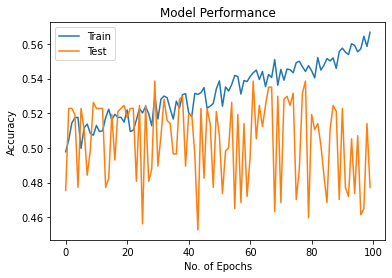

In [ ]:
### PLOT TRAINING AND VALIDATION LOSS AS FUNCTION OF NO. OF EPOCHS###
plt.plot(history_nn.history['accuracy'])
plt.plot(history_nn.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

In [ ]:
### PLOT OF MODEL PREDICTION VS ACTUAL VALUES ###
### PLOT OF TUNED MODEL PREDICTION VS ACTUAL VALUES ###
predicted_labels = nn_classifier.predict(X_test_pca)
actual_labels = Y_test



300/300 [==============================] - 0s 83us/step


In [ ]:
predicted_labels[0], actual_labels[0]

(1, 1)

In [ ]:
### HYPER-PARAMETER TUNING ###


### CREATE PARAMETER GRID FOR HYPERPARAMETER TUNING ###
param_grid = {
    'optimizer':['adam'#,
                     #'adamax',
                     #'nadam',
                     #'adadelta',
                     #'adagrad',
                     #'sgd'
                    ],
    'activation':[None#,
                  #'tanh',
                  #'sigmoid'
                  ],
    'use_bias':[True#,
                #False
                ],
    'initializer':[#'zeros',
                   #'normal',
                   #'uniform',
                   'glorot_uniform'
                   ],
    'regularizer':[None#,
                   #keras.regularizers.l1(0.001),
                   #keras.regularizers.l1(0.01)
                   ],
    'units':[50#,
             #100,
             #500
             ]
}

### CREATE GridSearchCV Object ###
nn_grid = GridSearchCV(estimator=nn_classifier,
                  param_grid=param_grid,
                  scoring=None,
                  n_jobs=-1,
                  cv=2,
                  refit=True,
                 verbose=1
                 )

nn_grid = nn_grid.fit(X_train_pca,Y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s finished


In [ ]:
### CREATE CUSTOM LOSS FUCNTION(RMSE) ###
### FOR USE AS EVALUATION METRIC FOR ALL REGRESSION TASKS ###
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

### MODEL 1 - SIMPLE DEEP NEURAL NET ### 

### METHOD FOR CREATING NEURAL NET ###
def create_simple_nn(input_shape=(np.shape(X_train_pca)[1],),loss=root_mean_squared_error,
              optimizer=keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,amsgrad=False),
              units = 100,
              activation=None,
              use_bias=True,
              initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.075,seed=777),
              regularizer=None,
              batch_size=32,
              epochs=1,
              shuffle=True):
    
    simple_nn = Sequential()

    #for layer in range(np.shape(X_train_pca)[1]-1):
    #  simple_nn.add(Dense(units=np.shape(X_train_pca)[1]-layer,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
    #                          kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
    #                          kernel_constraint=None,bias_constraint=None,input_shape=input_shape))


    simple_nn.add(Dense(units=units,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None,input_shape=input_shape))

    simple_nn.add(Dense(units=units//2,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    simple_nn.add(Dense(units=units//4,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    simple_nn.add(Dense(units=units//8,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    simple_nn.add(Dense(units=units//16,activation=activation,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    
    simple_nn.add(Dense(units=1,activation=activation ,use_bias=use_bias,kernel_initializer=initializer,bias_initializer=initializer,
                              kernel_regularizer=regularizer,bias_regularizer=regularizer,activity_regularizer=regularizer,
                              kernel_constraint=None,bias_constraint=None))

    simple_nn.compile(loss=loss,optimizer=optimizer)
    
    #history = simple_nn.fit(x=x_train,y=y_train,batch_size=params['batch_size'],epochs=params['epochs'],verbose=0,callbacks=None,shuffle=True)

    return simple_nn


In [ ]:
### HYPER-PARAMETER TUNING ###

### CREATE KerasRegressor Object ###
nn_regressor = KerasRegressor(build_fn=create_simple_nn,verbose=0)

### CREATE PARAMETER GRID FOR HYPERPARAMETER TUNING ###
param_grid = {
    'optimizer':['adam',
                     'adamax',
                     'nadam',
                     'adadelta',
                     'adagrad',
                     'sgd'
                    ],
    'activation':[None,'tanh','sigmoid'],
    'use_bias':[True,False],
    'initializer':['zeros','normal','uniform','glorot_uniform'],
    'regularizer':[None,keras.regularizers.l1(0.001),keras.regularizers.l1(0.01)],
    'units':[50,100,500]
}

### CREATE GridSearchCV Object ###
nn_grid = GridSearchCV(estimator=nn_regressor,
                  param_grid=param_grid,
                  scoring=None,
                  n_jobs=-1,
                  cv=2,
                  refit=True,
                 verbose=1
                 )

nn_grid = nn_grid.fit(X_train_pca,Y_train_std)

Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.0min


In [ ]:
gs.best_estimator_,gs.best_index_,gs.best_params_,gs.best_score_

(<keras.wrappers.scikit_learn.KerasRegressor at 0x7fb417a4ff98>,
 218,
 {'activation': None,
  'initializer': 'uniform',
  'optimizer': 'adam',
  'regularizer': None,
  'units': 100,
  'use_bias': True},
 -0.05628408580845446)

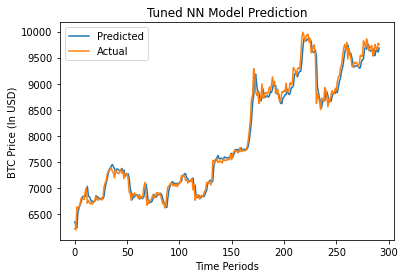

In [ ]:
### PLOT OF MODEL PREDICTION VS ACTUAL VALUES ###
### PLOT OF TUNED MODEL PREDICTION VS ACTUAL VALUES ###
predicted_labels = target_scaler.inverse_transform(gs.predict(X_test_pca))
actual_labels = Y_test
days = range(len(X_test))
plt.plot(predicted_labels)
plt.plot(actual_labels)
plt.title('Tuned NN Model Prediction')
plt.ylabel('BTC Price (In USD)')
plt.xlabel('Time Periods')
plt.legend(['Predicted','Actual'],loc='best')
plt.show()

In [ ]:
### CONVERT TRAINING AND TEST DATA INTO TIME-SERIES DATA ###
### NECESSARY FOR TRAINING RECURRENT NEURAL NETWORKS ###

x_train = list()
x_test = list()
lookback = 6


for j in range(np.shape(X_train_pca)[0]-lookback):
  x_train.append(list())
  for i in range(lookback):
    x_train[j].append(X_train_pca[i+j])


for j in range(np.shape(X_test_pca)[0]-lookback):
  x_test.append(list())
  for i in range(lookback):
    x_test[j].append(X_test_pca[i+j])


x_train, x_test = np.array(x_train), np.array(x_test)
#x_train, x_test = np.reshape(x_train,(np.shape(x_train)[0],np.shape(x_train)[1],1)),np.reshape(x_test,(np.shape(x_test)[0],np.shape(x_test)[1],1))

y_train, y_test = np.array(Y_train_std)[lookback-1:-1], np.array(Y_test_std)[lookback-1:-1]

np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test)


((5527, 6, 5), (5527, 1), (286, 6, 5), (286, 1))

In [ ]:
### MODEL 2 - LSTM RECURRENT NEURAL NETWORK ###

### METHOD TO CREATE LSTM RNN ###
def create_lstm_nn(input_shape = np.shape(x_train)[1:],units=100,loss=root_mean_squared_error,optimizer='adam',activation=None,recurrent_activation=None,use_bias=True,
                    kernel_initializer='zeros',recurrent_initializer='zeros',bias_initializer='zeros',
                    kernel_regularizer=None,recurrent_regularizer=None,bias_regularizer=None,activity_regularizer=None,
                          kernel_constraint=None,bias_constraint=None,recurrent_constraint=None,dropout=0.0,recurrent_dropout=0.0,unit_forget_bias=True):
  lstm_nn = Sequential()

  lstm_nn.add(LSTM(units = units, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
              kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
              unit_forget_bias=unit_forget_bias,kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
              kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
              implementation=2,return_sequences=True, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False,input_shape=input_shape))

  lstm_nn.add(LSTM(units = units//2, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
              kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
              unit_forget_bias=unit_forget_bias,kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
              kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
              implementation=2,return_sequences=True, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False))
  
  lstm_nn.add(LSTM(units = units//4, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
              kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
              unit_forget_bias=unit_forget_bias,kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
              kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
              implementation=2,return_sequences=False, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False))

  lstm_nn.add(Dense(units=units//8,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,
                          kernel_constraint=kernel_constraint,bias_constraint=bias_constraint))

  lstm_nn.add(Dense(units=1,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,
                          kernel_constraint=kernel_constraint,bias_constraint=bias_constraint))

  lstm_nn.compile(loss=loss,optimizer=optimizer)

  return lstm_nn



In [ ]:
### HYPER-PARAMETER TUNING ###

### TUNABLE HYPERPARAMETERS ###
### UNITS, OPTIMIZER, ACTIVATION, RECURRENT ACTIVATION, USE_BIAS, INITIALIZER(KERNEL,RECURRENT,BIAS), REGULARIZER(KERNEL,RECURRENT,BIAS),
### CONSTRAINTS(KERNEl,RECURRENT,BIAS), DROPOUT, RECURRENT DROPOUT, UNIT_FORGET_BIAS


### CREATE KerasRegressor Object ###
lstm_regressor = KerasRegressor(build_fn=create_lstm_nn,verbose=0)

### CREATE PARAMETER GRID FOR HYPERPARAMETER TUNING ###
lstm_param_grid = {
    'optimizer':['adam',
                     'adamax',
                     'nadam',
                     'adagrad'
                    ],
    'activation':[None,'tanh'],
    'recurrent_activation': [None,'sigmoid'],
    'use_bias':[True,False],
    'kernel_initializer':['zeros','glorot_uniform'],
    'recurrent_initializer':['orthogonal','glorot_uniform'],
    'bias_initializer':['glorot_uniform'],
    'kernel_regularizer':[None],
    'bias_regularizer':[None],
    'recurrent_regularizer':[None],
    'dropout':[0.0],
    'recurrent_dropout':[0.0],
    'unit_forget_bias':[True,False],
    'units':[50,500],
    'batch_size':[32],
    'epochs':[5]
}

### CREATE GridSearchCV Object ###
lstm_grid = GridSearchCV(estimator=lstm_regressor,
                  param_grid=lstm_param_grid,
                  scoring=None,
                  n_jobs=-1,
                  cv=2,
                  refit=True,
                 verbose=1
                 )

lstm_grid = lstm_grid.fit(x_train,y_train)

NameError: ignored

In [ ]:
### BEST CANDIDATE OBTAINED AFTER GRID SEARCH OVER PARAMETER SEARCH SPACE ###
lstm_grid.best_estimator_,lstm_grid.best_index_,lstm_grid.best_params_,lstm_grid.best_score_

NameError: ignored

In [ ]:
### PLOT OF TUNED MODEL PREDICTION VS ACTUAL VALUES ###
predicted_labels = target_scaler.inverse_transform(lstm_gs.predict(X_test_pca))
actual_labels = Y_test
plt.plot(predicted_labels)
plt.plot(actual_labels)
plt.title('Tuned LSTM Model Prediction')
plt.ylabel('BTC Price (In USD)')
plt.xlabel('Time Periods')
plt.legend(['Predicted','Actual'],loc='best')
plt.show()

In [ ]:
### METHOD TO CREATE GRU NETWORK ###
def create_gru_nn(units=500,loss=root_mean_squared_error,optimizer='adam',activation=None,recurrent_activation=None,use_bias=True,
                    kernel_initializer='zeros',recurrent_initializer='zeros',bias_initializer='zeros',
                    kernel_regularizer=None,recurrent_regularizer=None,bias_regularizer=None,activity_regularizer=None,
                          kernel_constraint=None,bias_constraint=None,recurrent_constraint=None,dropout=0.0,recurrent_dropout=0.0):
  gru_nn = Sequential()

  gru_nn.add(GRU(units = units, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
              kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
              kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
              kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
              implementation=2,return_sequences=True, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False, reset_after=False))

  gru_nn.add(GRU(units = units//2, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
              kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
              kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
              kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
              implementation=2,return_sequences=True, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False, reset_after=False))

  gru_nn.add(GRU(units = units//4, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
              kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
              kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
              kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
              implementation=2,return_sequences=False, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False, reset_after=False))

  gru_nn.add(Dense(units=units//8,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,
                          kernel_constraint=kernel_constraint,bias_constraint=bias_constraint))

  gru_nn.add(Dense(units=1,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,
                          kernel_constraint=kernel_constraint,bias_constraint=bias_constraint))

  gru_nn.compile(loss=loss,optimizer=optimizer)

  return gru_nn



In [ ]:
### CREATE KerasRegressor MODEL USING PREVIOUS FUNCTION ###
gru_regressor = KerasRegressor(build_fn=create_gru_nn,verbose=1,
                              optimizer=keras.optimizers.Adamax(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
                              units=500,
                              use_bias=True,
                              activation=None,
                              recurrent_activation='sigmoid',
                              kernel_initializer = keras.initializers.glorot_uniform(seed=980),
                              recurrent_initializer = 'orthogonal',
                              bias_initializer = keras.initializers.glorot_uniform(seed=988),
                              kernel_regularizer = None,
                              recurrent_regularizer = None,
                              bias_regularizer = None,
                              activity_regularizer = None,
                              dropout = 0.0,
                              recurrent_dropout = 0.0
                              )

### FIT MODEL TO TRAINING DATA ###
history_gru=gru_regressor.fit(x_train,y_train,epochs=50,shuffle=True,validation_split=0.2)

Train on 4404 samples, validate on 1101 samples
Epoch 1/50
4404/4404 [==============================] - 14s 3ms/step - loss: 0.8818 - val_loss: 0.1905
Epoch 2/50
4404/4404 [==============================] - 14s 3ms/step - loss: 0.1601 - val_loss: 0.0874
Epoch 3/50
4404/4404 [==============================] - 16s 4ms/step - loss: 0.1492 - val_loss: 0.0983
Epoch 4/50
4404/4404 [==============================] - 14s 3ms/step - loss: 0.1366 - val_loss: 0.0808
Epoch 5/50
4404/4404 [==============================] - 13s 3ms/step - loss: 0.1330 - val_loss: 0.0725
Epoch 6/50
4404/4404 [==============================] - 13s 3ms/step - loss: 0.1092 - val_loss: 0.0962
Epoch 7/50
4404/4404 [==============================] - 13s 3ms/step - loss: 0.1116 - val_loss: 0.0592
Epoch 8/50
4404/4404 [==============================] - 13s 3ms/step - loss: 0.1000 - val_loss: 0.1081
Epoch 9/50
4404/4404 [==============================] - 13s 3ms/step - loss: 0.1040 - val_loss: 0.0731
Epoch 10/50
4404/4404 [==

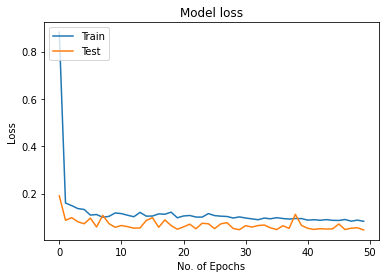

In [ ]:
### PLOT TRAINING AND VALIDATION LOSS AS FUNCTION OF NO. OF EPOCHS###
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

285/285 [==============================] - 0s 1ms/step


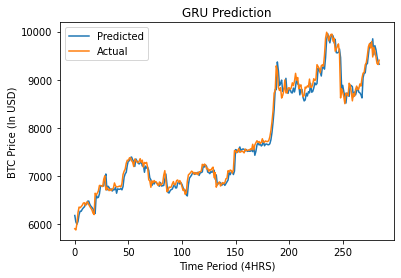

In [ ]:
### PLOT OF MODEL PREDICTED VALUES VS ACTUAL VALUES ###
predicted_labels = target_scaler.inverse_transform(gru_regressor.predict(x_test))
actual_labels = target_scaler.inverse_transform(y_test) 
plt.plot(predicted_labels)
plt.plot(actual_labels)
plt.title('GRU Prediction')
plt.ylabel('BTC Price (In USD)')
plt.xlabel('Time Period (4HRS)')
plt.legend(['Predicted','Actual'],loc='best')
plt.show()